In [8]:
import pandas as pd

orders = pd.read_csv('./data/Orders.csv')

pd.set_option('display.max_columns', None)

In [9]:
orders.shape

(51290, 24)

In [10]:
orders.Profit = orders.Profit.replace('[\$,]', '', regex=True).astype(float)
orders.Sales = orders.Sales.replace('[\$,]', '', regex=True).astype(float)

In [11]:
orders.sample(5)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
22133,8168,MX-2013-EC1405018-41599,11/21/13,11/23/13,Second Class,EC-1405018,Erin Creighton,Consumer,NaN,Brasília,Federal District,Brazil,South America,LATAM,OFF-FA-5472,Office Supplies,Fasteners,"OIC Push Pins, Assorted Sizes",32.96,4,0.0,1.60,10.438,Critical
14558,15864,ES-2015-ZC21910139-42366,12/28/15,12/31/15,First Class,ZC-21910139,Zuschuss Carroll,Consumer,NaN,Wolverhampton,England,United Kingdom,Northern Europe,Europe,OFF-EN-3105,Office Supplies,Envelopes,"Ames Manila Envelope, Security-Tint",135.45,5,0.0,54.15,20.550,Medium
20172,28518,ID-2015-ST205307-42336,11/28/15,12/5/15,Standard Class,ST-205307,Shui Tom,Consumer,NaN,Bundaberg,Queensland,Australia,Oceania,Asia Pacific,FUR-FU-3928,Furniture,Furnishings,"Deflect-O Clock, Black",90.56,2,0.1,-3.04,12.320,Low
23105,27003,IN-2014-BP1118527-41648,1/9/14,1/14/14,Standard Class,BP-1118527,Ben Peterman,Corporate,NaN,Jining,Shandong,China,Eastern Asia,Asia Pacific,OFF-EN-4443,Office Supplies,Envelopes,"GlobeWeis Mailers, Recycled",74.70,2,0.0,33.60,9.590,High
32620,9342,MX-2013-AF1087051-41489,8/3/13,8/9/13,Standard Class,AF-1087051,Art Ferguson,Consumer,NaN,Mixco,Guatemala,Guatemala,Central America,LATAM,FUR-BO-3894,Furniture,Bookcases,"Dania Corner Shelving, Mobile",166.12,2,0.0,44.84,4.418,Medium


In [12]:
orders['Month'] = pd.DatetimeIndex(orders['Order.Date']).month

In [32]:
def month_to_season(month):
  if month in [3,4,5]:
    month = '1_Spring'
  elif month in [6,7,8]:
    month = '2_Summer'
  elif month in [9,10,11]:
    month = '3_Fall'
  else:
    month = '4_Winter'
  return(month)

In [33]:
orders['Season'] = orders.Month.apply(month_to_season)

In [34]:
orders.sample(5)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Season
21664,29684,ID-2015-NR18550102-42078,3/15/15,3/21/15,Standard Class,NR-18550102,Nick Radford,Consumer,NaN,Makati,National Capital,Philippines,Southeastern Asia,Asia Pacific,OFF-BI-2899,Office Supplies,Binders,"Acco Binding Machine, Clear",128.90,3,0.15,30.26,10.85,Medium,3,1_Spring
32057,43169,EG-2015-LS694538-42024,1/20/15,1/22/15,First Class,LS-694538,Linda Southworth,Corporate,NaN,Alexandria,Al Iskandariyah,Egypt,North Africa,Africa,OFF-PA-4182,Office Supplies,Paper,"Enermax Parchment Paper, Multicolor",16.80,1,0.00,5.04,4.63,High,1,4_Winter
11658,46372,UP-2014-EM3810137-41979,12/6/14,12/12/14,Standard Class,EM-3810137,Eleni McCrary,Corporate,NaN,Nizhyn,Chernihiv,Ukraine,Eastern Europe,Europe,FUR-FU-4065,Furniture,Furnishings,"Eldon Frame, Duo Pack",465.24,4,0.00,209.28,27.55,Medium,12,4_Winter
12975,18988,ES-2014-SS208758-41683,2/13/14,2/19/14,Standard Class,SS-208758,Sung Shariari,Consumer,NaN,Vienna,Vienna,Austria,Western Europe,Europe,OFF-BI-6382,Office Supplies,Binders,"Wilson Jones Binding Machine, Clear",338.94,7,0.00,101.64,24.06,Medium,2,4_Winter
43775,22362,IN-2015-SB2017088-42336,11/28/15,12/2/15,Standard Class,SB-2017088,Sarah Bern,Consumer,NaN,Yangon,Yangon,Myanmar (Burma),Southeastern Asia,Asia Pacific,OFF-BI-4810,Office Supplies,Binders,"Ibico Binder Covers, Recycled",11.63,1,0.17,-1.84,1.79,Medium,11,3_Fall


In [42]:
season_category = orders.groupby(['Season','Category']).agg({'Row.ID':'count', 'Profit':'sum'})
season_category = season_category.reset_index()
season_category = season_category.set_index('Season')
season_category.sort_values(by=['Season'], axis=0)

,Category,Row.ID,Profit
Season,,,
1_Spring,Furniture,1856,41635.46
1_Spring,Office Supplies,6054,104256.93
1_Spring,Technology,1916,126773.70
2_Summer,Furniture,2488,63350.29
2_Summer,Office Supplies,8381,136797.00
2_Summer,Technology,2693,175576.04
3_Fall,Furniture,3347,113388.94
3_Fall,Office Supplies,10170,163654.58
3_Fall,Technology,3308,227549.67


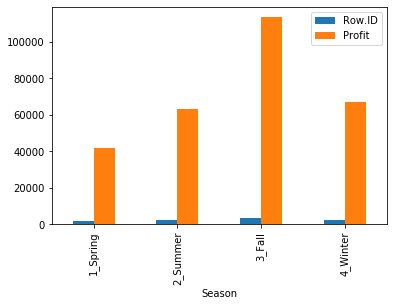

In [43]:
season_category[season_category.Category =='Furniture'].plot.bar()

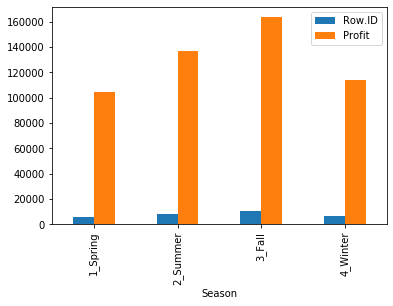

In [44]:
season_category[season_category.Category =='Office Supplies'].plot.bar()

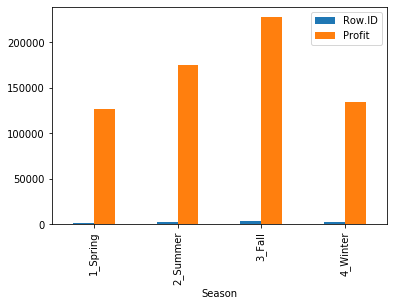

In [45]:
season_category[season_category.Category =='Technology'].plot.bar()

Furniture category had a slight drop in sales in spring and summer, but overall all categories followed a similar trend from overall (Winter < Spring < Summer < Fall)

### Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

	1. How much profit did we lose due to returns each year?

	2. How many customer returned more than once? more than 5 times?

	3. Which regions are more likely to return orders?

	4. Which categories (sub-categories) of products are more likely to be returned?

- ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [47]:
# how much profit did we lose? -> sum the price column in returns

In [48]:
returns.shape

(1079, 3)

In [49]:
returns.sample(5)

,Returned,Order ID,Region
95,Yes,IN-2012-TB2152059-41207,Southeastern Asia
195,Yes,MX-2013-PO1885051-41338,Central America
936,Yes,IT-2013-BW11065139-41370,Northern Europe
234,Yes,MX-2012-KT1646518-41017,South America
767,Yes,IN-2014-IM1507058-41812,Southern Asia


In [58]:
returns.Returned.unique()

array(['Yes'], dtype=object)

In [61]:
returns.columns

Index(['Returned', 'Order ID', 'Region'], dtype='object')

In [63]:
orders['Order.ID'].sample(5)

24962     ID-2013-SC2080059-41380
10489    CA-2015-CA12265140-42313
49819     US-2015-PR1888055-42116
41054     IT-2012-ME1732048-41222
23544     MX-2014-VS2182018-41871
Name: Order.ID, dtype: object

In [205]:
returns = pd.read_csv('./data/Returns.csv')
order_price = orders[['Order.ID', 'Customer.Name', 'Sub.Category', 'Sales']]
returns = returns.merge(order_price, how='left', left_on='Order ID', right_on='Order.ID', copy=False)
returns = returns.drop(['Order.ID'], axis=1)
returns

,Returned,Order ID,Region,Customer.Name,Sub.Category,Sales
0,Yes,CA-2012-SA20830140-41210,Central US,Sue Ann Reed,Phones,2735.95
1,Yes,IN-2012-PB19210127-41259,Eastern Asia,Phillip Breyer,Tables,1715.16
2,Yes,IN-2012-PB19210127-41259,Eastern Asia,Phillip Breyer,Bookcases,2197.50
3,Yes,IN-2012-PB19210127-41259,Eastern Asia,Phillip Breyer,Tables,1356.03
4,Yes,IN-2012-PB19210127-41259,Eastern Asia,Phillip Breyer,Chairs,882.15
...,...,...,...,...,...,...
2215,Yes,IN-2014-DA1345058-41769,Southern Asia,Dianna Arnett,Binders,12.57
2216,Yes,US-2013-HG14845140-41530,Eastern US,Harry Greene,Binders,2.41
2217,Yes,US-2013-SJ2021582-41543,Central America,Sarah Jordon,Furnishings,181.12
2218,Yes,CA-2015-EB13870140-42269,Eastern US,Emily Burns,Binders,1.91


In [188]:
print('The cost of returned sales is $%.2f' % sum(returns.Sales))

The cost of returned sales is $525932.41


In [ ]:
# customers returned more than once -> aggregate customer.name

In [189]:
returned_names = returns.groupby('Customer.Name').agg({'Customer.Name':'count'}).rename_axis(None)
print('The number of people who made a return is %i' % returned_names.shape[0])
print('The number of people who made more than 5 returns is %i' % sum(returned_names['Customer.Name'] > 5))

The number of people who made a return is 593
The number of people who made more than 5 returns is 124


In [ ]:
# regions more likely to return -> aggregate region and count

In [195]:
returns.Sales

0       2735.95
1       1715.16
2       2197.50
3       1356.03
4        882.15
         ...   
2215      12.57
2216       2.41
2217     181.12
2218       1.91
2219      25.83
Name: Sales, Length: 2220, dtype: float64

In [201]:
print('The worst areas for returns are:')
returns.groupby('Region').agg({'Sales':'sum'}).sort_values('Sales',ascending=False).head(5)

The worst areas for returns are:


,Sales
Region,
Western Europe,72669.57
Eastern Asia,47798.05
Oceania,46943.35
Central America,44334.78
Western US,44310.00


In [ ]:
# categories most likely to be return -> aggregate count of 

In [206]:
returned_categories = returns.groupby('Sub.Category').agg({'Sub.Category': 'count'}).rename_axis(None)
print('The categories most likely to be returned are:')
returned_categories.sort_values('Sub.Category', ascending=False).head(5)

The categories most likely to be returned are:


,Sub.Category
Binders,269
Art,217
Storage,212
Paper,150
Chairs,147
